## Deep Learning Course Project - Gesture Recognition
- Submitted by: Shreedhar, Yubaraj and Sabyasachi

### Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

| Gesture     | Corresponding Action         |
|:-----------:|-----------------------------:|
|Thumbs Up    | Increase the volume          |
|Thumbs Down  | Decrease the volume.         |
|Left Swipe   | 'Jump' backwards 10 seconds. |
|Right Swipe  | 'Jump' forward 10 seconds.   |
|Stop         | Pause the movie.             |

Each video is a sequence of 30 frames (or images).

**Objectives:**

Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [27]:
## Checking the GPU configuration

!nvidia-smi


Sun Feb  7 20:50:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    58W / 149W |  10961MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Importing the required Libraries 

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

## initialize the random seed 
np.random.seed(40)
import random as rn
rn.seed(40)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(40)

import cv2
import matplotlib.pyplot as plt
% matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

## Create a variable for the data folder 
project_folder='Project_data'

Using TensorFlow backend.


### Create a user defined function for plotting 

In [2]:
# This function will plot with training loss, validation loss, training accuracy and validation accuracy

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### Generators
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

We have created the class keeping in mind the reusability of code.

In [3]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

### Model
Here we made the model using different functionalities that Keras provides. we are using Conv3D and MaxPooling3D for our model creation. Also we have used the last layer as the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Initial Model

We have created a class which will be inherited from ModelBuilder class. For Conv3D Layers we have used 'relu' as activation function, padding as 'same' tries to pad evenly left and right, but if the amount of columns to be added is odd, it will add the extra column to the right.

In [5]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [6]:
# Object creation of ModelConv3D1 as Initial Model.
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

### Crop and view the sample

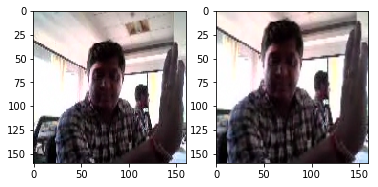

In [7]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])

### Train the Initial model

In [8]:
conv_3d1.train_model(conv_3d1_model)

Epoch 1/1
67/67 [==============================] - 93s 1s/step - loss: 1.6232 - categorical_accuracy: 0.4010 - val_loss: 1.7083 - val_categorical_accuracy: 0.4100

Epoch 00001: val_loss improved from inf to 1.70834, saving model to model_init_2021-02-0700_45_43.730364/model-00001-1.62702-0.39819-1.70834-0.41000.h5


In [9]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


### Experiment with different resolution, number of images and batch size.

In [10]:
# Train the model with image height=160,image width=160,frames_to_sample=16,batch size=30,num_epochs=2
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - 53s 2s/step - loss: 1.5766 - categorical_accuracy: 0.4262 - val_loss: 1.6735 - val_categorical_accuracy: 0.3700

Epoch 00001: val_loss improved from inf to 1.67355, saving model to model_init_2021-02-0700_47_22.839385/model-00001-1.56564-0.42986-1.67355-0.37000.h5
Epoch 2/2
23/23 [==============================] - 43s 2s/step - loss: 1.0418 - categorical_accuracy: 0.5970 - val_loss: 1.8832 - val_categorical_accuracy: 0.4400

Epoch 00002: val_loss did not improve from 1.67355


In [11]:
# image_height=100,image_width=100,frames_to_sample=30,batch_size=20,num_epochs=2
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 [==============================] - 77s 2s/step - loss: 1.5637 - categorical_accuracy: 0.4290 - val_loss: 1.2962 - val_categorical_accuracy: 0.4900

Epoch 00001: val_loss improved from inf to 1.29615, saving model to model_init_2021-02-0700_49_05.231742/model-00001-1.55444-0.43137-1.29615-0.49000.h5
Epoch 2/2
34/34 [==============================] - 69s 2s/step - loss: 1.1967 - categorical_accuracy: 0.5482 - val_loss: 1.1758 - val_categorical_accuracy: 0.5100

Epoch 00002: val_loss improved from 1.29615 to 1.17579, saving model to model_init_2021-02-0700_49_05.231742/model-00002-1.14181-0.55354-1.17579-0.51000.h5


In [12]:
# image_height=160,image_width=160,frames_to_sample=30,batch_size=15,num_epochs=2
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 91s 2s/step - loss: 1.5191 - categorical_accuracy: 0.4487 - val_loss: 1.4155 - val_categorical_accuracy: 0.5200

Epoch 00001: val_loss improved from inf to 1.41553, saving model to model_init_2021-02-0700_51_37.542540/model-00001-1.54094-0.43891-1.41553-0.52000.h5
Epoch 2/2
45/45 [==============================] - 83s 2s/step - loss: 1.0434 - categorical_accuracy: 0.6000 - val_loss: 0.9160 - val_categorical_accuracy: 0.7100

Epoch 00002: val_loss improved from 1.41553 to 0.91598, saving model to model_init_2021-02-0700_51_37.542540/model-00002-1.03916-0.59879-0.91598-0.71000.h5


In [13]:
# image_height=100,image_width=100,frames_to_sample=16,batch_size=60,num_epochs=2
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 47s 4s/step - loss: 1.7454 - categorical_accuracy: 0.3543 - val_loss: 2.2071 - val_categorical_accuracy: 0.4700

Epoch 00001: val_loss improved from inf to 2.20714, saving model to model_init_2021-02-0700_54_38.905521/model-00001-1.77878-0.35596-2.20714-0.47000.h5
Epoch 2/2
12/12 [==============================] - 34s 3s/step - loss: 1.1524 - categorical_accuracy: 0.5674 - val_loss: 1.8511 - val_categorical_accuracy: 0.4400

Epoch 00002: val_loss improved from 2.20714 to 1.85111, saving model to model_init_2021-02-0700_54_38.905521/model-00002-1.14191-0.55958-1.85111-0.44000.h5


### Inferences (Initial model)

- As we see from the above experiments "image resolution" and number of frames in sequence have more impact on training time than batch_size
- We can consider the Batch Size around 15-40
- We will use the resoulution in between  160 X 160, 100 X 100 as per  the model performance

## Model - 1
In this model we will consider our initial model and will run with batch size 40 amd 15 Epochs 

In [14]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
# image_height=160,image_width=160,frames_to_sample=20,batch_size=40,num_epochs=15
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_22 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 10, 80, 80, 32)    128       
__________

In [16]:
print("Total Parameters:", conv_3d1_model.count_params())
model1 = conv_3d1.train_model(conv_3d1_model)

Total Parameters: 1117061
Epoch 1/15
17/17 [==============================] - 70s 4s/step - loss: 1.4456 - categorical_accuracy: 0.4532 - val_loss: 2.4879 - val_categorical_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 2.48788, saving model to model_init_2021-02-0700_56_09.665109/model-00001-1.45643-0.44947-2.48788-0.40000.h5
Epoch 2/15
17/17 [==============================] - 50s 3s/step - loss: 0.9397 - categorical_accuracy: 0.6204 - val_loss: 1.5657 - val_categorical_accuracy: 0.4600

Epoch 00002: val_loss improved from 2.48788 to 1.56574, saving model to model_init_2021-02-0700_56_09.665109/model-00002-0.94825-0.61538-1.56574-0.46000.h5
Epoch 3/15
17/17 [==============================] - 56s 3s/step - loss: 0.7281 - categorical_accuracy: 0.7165 - val_loss: 0.9272 - val_categorical_accuracy: 0.6400

Epoch 00003: val_loss improved from 1.56574 to 0.92720, saving model to model_init_2021-02-0700_56_09.665109/model-00003-0.72464-0.71493-0.92720-0.64000.h5
Epoch 4/15
17/1

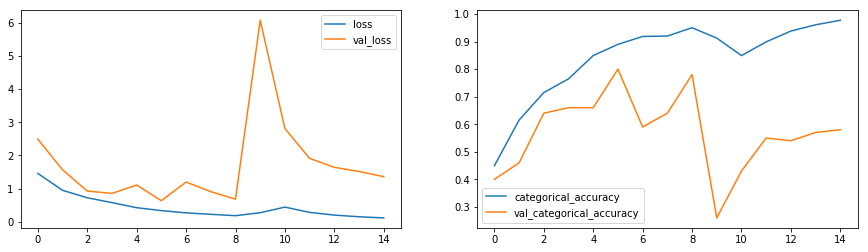

In [17]:
plot(model1)

### Inferences ( Model - 1)

- Total Parameters: 1,117,061
- Categorical and validation accuracy are 97% and 58% respectively in the last epoch.
- Model seem to overfit

## Model - 2 
In this model we will add drop out layers , will make batch size 20 and number of epochs = 25

In [18]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_26 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 10, 80, 80, 32)    128       
__________

In [19]:
print("Total Parameters:", conv_3d2_model.count_params())
model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Parameters: 3638981
Epoch 1/25
34/34 [==============================] - 134s 4s/step - loss: 1.9629 - categorical_accuracy: 0.3786 - val_loss: 9.3096 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 9.30958, saving model to model_init_2021-02-0701_10_23.573420/model-00001-1.95037-0.37557-9.30958-0.23000.h5
Epoch 2/25
34/34 [==============================] - 119s 4s/step - loss: 1.4906 - categorical_accuracy: 0.4963 - val_loss: 5.9440 - val_categorical_accuracy: 0.2600

Epoch 00002: val_loss improved from 9.30958 to 5.94397, saving model to model_init_2021-02-0701_10_23.573420/model-00002-1.45023-0.50452-5.94397-0.26000.h5
Epoch 3/25
34/34 [==============================] - 125s 4s/step - loss: 1.2428 - categorical_accuracy: 0.5644 - val_loss: 1.1988 - val_categorical_accuracy: 0.5900

Epoch 00003: val_loss improved from 5.94397 to 1.19880, saving model to model_init_2021-02-0701_10_23.573420/model-00003-1.24290-0.57014-1.19880-0.59000.h5
Epoch 4/25
3

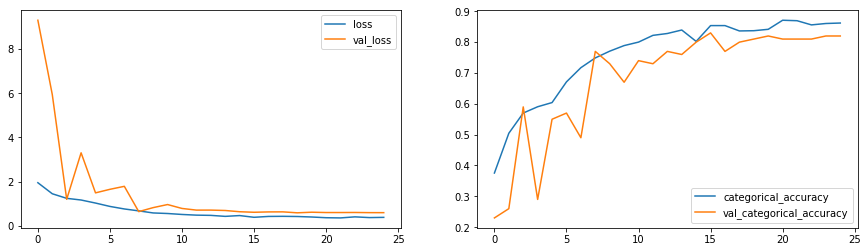

In [20]:
plot(model2)

### Inferences ( Model - 2)

- Best weights are saved automatically.
- Total Parameters: 3638981
- Categorical and validation accuracy are 86% and 82% respectively in the last epoch.

## Model - 3 
Lets reduce the filter size to 2,2,2 from 3,3,3 and image resolution to 120 X 120 from 160 X 160 ,Batch size = 30 and no. of Epochs = 25

In [21]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [22]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_29 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_30 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 8, 60, 60, 32)     128       
__________

In [23]:
print("Total Parameters:", conv_3d3_model.count_params())
model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Parameters: 1762613
Epoch 1/25
23/23 [==============================] - 90s 4s/step - loss: 2.2603 - categorical_accuracy: 0.3116 - val_loss: 1.2030 - val_categorical_accuracy: 0.5300

Epoch 00001: val_loss improved from inf to 1.20302, saving model to model_init_2021-02-0702_02_27.307004/model-00001-2.24451-0.31071-1.20302-0.53000.h5
Epoch 2/25
23/23 [==============================] - 76s 3s/step - loss: 1.7663 - categorical_accuracy: 0.4225 - val_loss: 1.0176 - val_categorical_accuracy: 0.6200

Epoch 00002: val_loss improved from 1.20302 to 1.01765, saving model to model_init_2021-02-0702_02_27.307004/model-00002-1.70527-0.43891-1.01765-0.62000.h5
Epoch 3/25
23/23 [==============================] - 82s 4s/step - loss: 1.3868 - categorical_accuracy: 0.5167 - val_loss: 1.0385 - val_categorical_accuracy: 0.6400

Epoch 00003: val_loss did not improve from 1.01765
Epoch 4/25
23/23 [==============================] - 81s 4s/step - loss: 1.2889 - categorical_accuracy: 0.5507 - val_loss

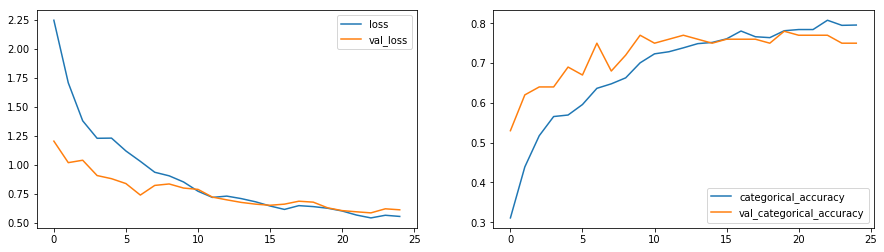

In [24]:
plot(model3)

### Inferences ( Model - 3)

- Total Parameters: 1762613
- Categorical and validation accuracy are 79% and 75% respectively in the last epoch.
- The validation loss did not improve from 0.58494 

## Model - 4
Lets add few more layers keeping Batch size = 20 and no. of Epochs = 25

In [25]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [26]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_34 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [27]:

print("Total Parameterss:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Parameterss: 2556533
Epoch 1/25
34/34 [==============================] - 113s 3s/step - loss: 2.0338 - categorical_accuracy: 0.3709 - val_loss: 7.5615 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 7.56149, saving model to model_init_2021-02-0702_37_00.447772/model-00001-2.01871-0.37179-7.56149-0.23000.h5
Epoch 2/25
34/34 [==============================] - 92s 3s/step - loss: 1.4103 - categorical_accuracy: 0.4996 - val_loss: 3.5506 - val_categorical_accuracy: 0.3200

Epoch 00002: val_loss improved from 7.56149 to 3.55062, saving model to model_init_2021-02-0702_37_00.447772/model-00002-1.41488-0.49548-3.55062-0.32000.h5
Epoch 3/25
34/34 [==============================] - 92s 3s/step - loss: 1.3745 - categorical_accuracy: 0.5166 - val_loss: 1.3278 - val_categorical_accuracy: 0.6000

Epoch 00003: val_loss improved from 3.55062 to 1.32779, saving model to model_init_2021-02-0702_37_00.447772/model-00003-1.32475-0.52112-1.32779-0.60000.h5
Epoch 4/25
34

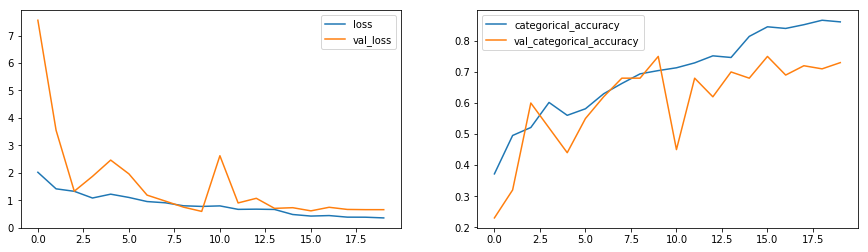

In [28]:
plot(history_model4)

### Inferences ( Model - 4)

- Total Parameters: 2556533
- Categorical and validation accuracy are 86% and 73% respectively in the last epoch.
- We can see the validation loss did not improve from 0.59194, so early stopping stoped the epoch automatically and just ran 20/25 epochs.

## Model - 5 
Lets add dropout at convolutional layers i.e after the MaxPooling3D layer

In [29]:
class ModelConv3D5(ModelBuilder):    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_41 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_42 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - 103s 3s/step - loss: 1.7958 - categorical_accuracy: 0.3966 - val_loss: 2.9203 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 2.92032, saving model to model_init_2021-02-0703_08_27.739803/model-00001-1.79430-0.39819-2.92032-0.36000.h5
Epoch 2/15
34/34 [==============================] - 93s 3s/step - loss: 1.4355 - categorical_accuracy: 0.4765 - val_loss: 2.6921 - val_categorical_accuracy: 0.4400

Epoch 00002: val_loss improved from 2.92032 to 2.69209, saving model to model_init_2021-02-0703_08_27.739803/model-00002-1.43621-0.47587-2.69209-0.44000.h5
Epoch 3/15
34/34 [==============================] - 93s 3s/step - loss: 1.1169 - categorical_accuracy: 0.5670 - val_loss: 2.4522 - val_categorical_accuracy: 0.5000

Epoch 00003: val_loss improved from 2.69209 to 2.45221, saving model to model_init_2021-02-0703_08_27.739803/model-00003-1.10876-0.57692-2.45221-0.50000.h5
Epoch 4/15
34/34 [

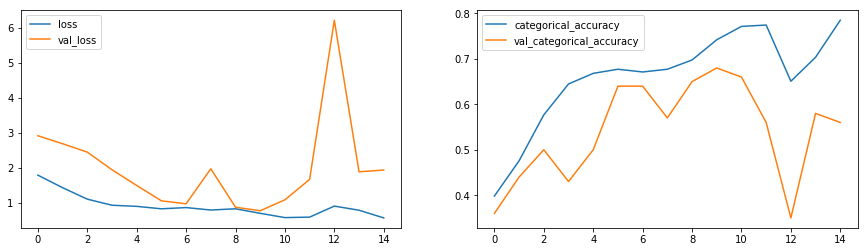

In [31]:
print("Total Params:", conv_3d5_model.count_params())
model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)
plot(model5)

### Inferences ( Model - 5)

- Total Parameters: 2,556,533
- Categorical and validation accuracy are 79% and 56% respectively in the last epoch.
- The model seem to overfit

Let us try to reduce the parameters and see the performance in the coming models.

## Model - 6 Increase the Dropouts

Let us increase the dropout to 0.5 (While creating the object).

In [32]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [33]:
# Using dense_neurons=256,dropout=0.5.
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=120,image_width=120)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d6_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_49 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_50 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [34]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 105s 3s/step - loss: 2.0380 - categorical_accuracy: 0.3595 - val_loss: 7.2464 - val_categorical_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 7.24643, saving model to model_init_2021-02-0703_32_18.749219/model-00001-2.02156-0.36425-7.24643-0.25000.h5
Epoch 2/25
34/34 [==============================] - 93s 3s/step - loss: 1.5412 - categorical_accuracy: 0.4798 - val_loss: 3.8703 - val_categorical_accuracy: 0.3000

Epoch 00002: val_loss improved from 7.24643 to 3.87035, saving model to model_init_2021-02-0703_32_18.749219/model-00002-1.53751-0.47511-3.87035-0.30000.h5
Epoch 3/25
34/34 [==============================] - 92s 3s/step - loss: 1.2458 - categorical_accuracy: 0.5625 - val_loss: 1.3535 - val_categorical_accuracy: 0.6100

Epoch 00003: val_loss improved from 3.87035 to 1.35346, saving model to model_init_2021-02-0703_32_18.749219/model-00003-1.23534-0.56410-1.35346-0.61000.h5
Epoch 4/25
34/34 [

### Inferences (Model - 6)

- Total Parameters: 2,556,533
- Categorical and validation accuracy are 90% and 76% respectively in the last epoch.
- The model seem to overfit

Let us try to reduce the parameters and see the performance in the coming models.

## Model - 7 
Reducing few more parameters (for checking the performance)

In [10]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
# Let us reduce the dense_neurons to 64 and keep the dropout to 0.25
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 32)     128       
__________

Total Parameterss: 504709
Epoch 1/25
34/34 [==============================] - 199s 6s/step - loss: 1.9441 - categorical_accuracy: 0.3267 - val_loss: 1.7107 - val_categorical_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 1.71066, saving model to model_init_2021-02-0716_38_01.412874/model-00001-1.92962-0.33484-1.71066-0.40000.h5
Epoch 2/25
34/34 [==============================] - 115s 3s/step - loss: 1.3700 - categorical_accuracy: 0.5055 - val_loss: 1.1743 - val_categorical_accuracy: 0.5500

Epoch 00002: val_loss improved from 1.71066 to 1.17428, saving model to model_init_2021-02-0716_38_01.412874/model-00002-1.33499-0.50980-1.17428-0.55000.h5
Epoch 3/25
34/34 [==============================] - 90s 3s/step - loss: 1.0726 - categorical_accuracy: 0.5883 - val_loss: 1.0408 - val_categorical_accuracy: 0.6300

Epoch 00003: val_loss improved from 1.17428 to 1.04077, saving model to model_init_2021-02-0716_38_01.412874/model-00003-1.09129-0.58220-1.04077-0.63000.h5
Epoch 4/25
34

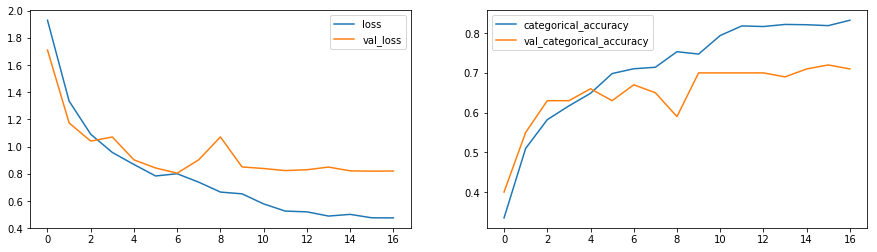

In [12]:
print("Total Parameterss:", conv_3d7_model.count_params())
model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)
plot(model7)

### Inferences (Model-7)

- Total Parameters: 504,709
- Categorical and validation accuracy are 82% and 71% respectively in the last epoch.
- Epoch 00017: val_loss did not improve from 0.80514 hence early stopping

## Model 8 CNN + LSTM model 

In [4]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
# image_height=120,image_width=120,frames_to_sample=18,batch_size=20,num_epochs=20,dense_neurons=128,dropout=0.25
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

Total Parameters: 1657445
Epoch 1/20
34/34 [==============================] - 166s 5s/step - loss: 1.4323 - categorical_accuracy: 0.3915 - val_loss: 1.3840 - val_categorical_accuracy: 0.3700

Epoch 00001: val_loss improved from inf to 1.38397, saving model to model_init_2021-02-0717_05_50.861517/model-00001-1.44176-0.38462-1.38397-0.37000.h5
Epoch 2/20
34/34 [==============================] - 98s 3s/step - loss: 1.1618 - categorical_accuracy: 0.5051 - val_loss: 1.3160 - val_categorical_accuracy: 0.4900

Epoch 00002: val_loss improved from 1.38397 to 1.31601, saving model to model_init_2021-02-0717_05_50.861517/model-00002-1.14631-0.51357-1.31601-0.49000.h5
Epoch 3/20
34/34 [==============================] - 100s 3s/step - loss: 0.9559 - categorical_accuracy: 0.6255 - val_loss: 0.9881 - val_categorical_accuracy: 0.6100

Epoch 00003: val_loss improved from 1.31601 to 0.98813, saving model to model_init_2021-02-0717_05_50.861517/model-00003-0.95660-0.62443-0.98813-0.61000.h5
Epoch 4/20
34

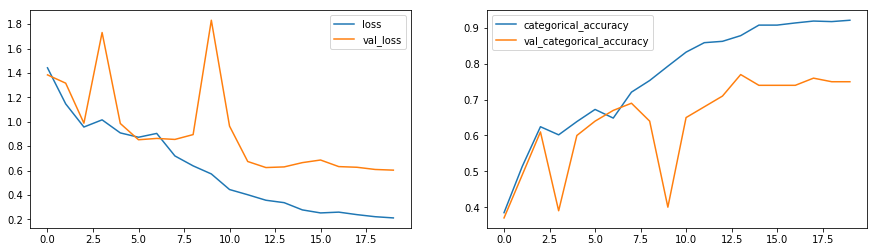

In [15]:
print("Total Parameters:", rnn_cnn1_model.count_params())
model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)
plot(model8)

### Inferences (Model 8)

- Total Parameters: 1,657,445
- Categorical and validation accuracy are 92% and 75% respectively in the last epoch.
- Epoch 00020: val_loss improved from 0.60878 to 0.60324, saving model to model_init_2021-02-0717_05_50.861517/model-00020-0.21173-0.92157-0.60324-0.75000.h5

As we are seeing some overfitting, let us try with the augmentation: 

## Prep work for creating Model with augmentation

In [16]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                   
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

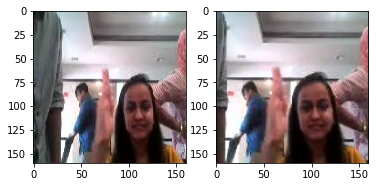

In [17]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])

## Model-9 With Augmentation ( model )
Lets build the model as similar to model 2

In [18]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_6 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 80, 80, 32)    128       
__________

Total Parameters: 3638981
Epoch 1/20
34/34 [==============================] - 164s 5s/step - loss: 1.9874 - categorical_accuracy: 0.3705 - val_loss: 1.2344 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2021-02-0717_40_29.571562/model-00001-1.96574-0.37557-1.23437-0.55000.h5
Epoch 2/20
34/34 [==============================] - 125s 4s/step - loss: 1.4273 - categorical_accuracy: 0.5213 - val_loss: 1.1990 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2021-02-0717_40_29.571562/model-00002-1.40363-0.52187-1.19905-0.61000.h5
Epoch 3/20
34/34 [==============================] - 129s 4s/step - loss: 1.2095 - categorical_accuracy: 0.5879 - val_loss: 0.6934 - val_categorical_accuracy: 0.7400

Epoch 00003: saving model to model_init_2021-02-0717_40_29.571562/model-00003-1.21827-0.58597-0.69340-0.74000.h5
Epoch 4/20
34/34 [==============================] - 128s 4s/step - loss: 1.0105 - categorical_accuracy: 0.6416 - val_loss: 0.6902 - val_c

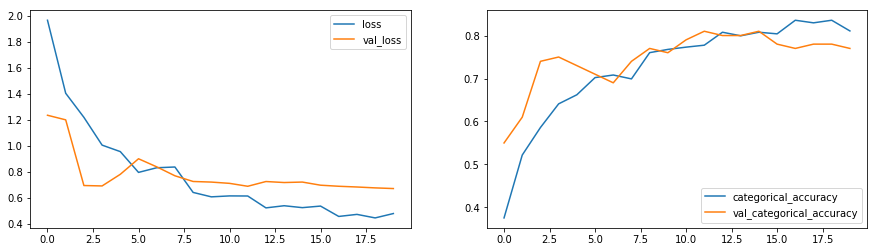

In [20]:
print("Total Parameters:", conv_3d9_model.count_params())
model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)
plot(model9)

### Inferences (Model 9)

- Total Parameters: 3,638,981
- Categorical and validation accuracy are 79% and 77% respectively in the last epoch.
- The Model 9 training accuracy has reduced from 92% to 79% as compare with Model-8

## Model-10 (with augmentation similar to model 7)

In [21]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [22]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(dense_neurons=64,dropout=0.25)
conv_3d10_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_10 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 60, 60, 32)     128       
__________

Total Parameterss: 504709
Epoch 1/25
34/34 [==============================] - 88s 3s/step - loss: 1.9291 - categorical_accuracy: 0.3355 - val_loss: 1.0907 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2021-02-0718_23_07.685845/model-00001-1.95445-0.32730-1.09071-0.55000.h5
Epoch 2/25
34/34 [==============================] - 81s 2s/step - loss: 1.4247 - categorical_accuracy: 0.4463 - val_loss: 0.9768 - val_categorical_accuracy: 0.6300

Epoch 00002: saving model to model_init_2021-02-0718_23_07.685845/model-00002-1.43852-0.44495-0.97684-0.63000.h5
Epoch 3/25
34/34 [==============================] - 84s 2s/step - loss: 1.1392 - categorical_accuracy: 0.5511 - val_loss: 1.0117 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2021-02-0718_23_07.685845/model-00003-1.14583-0.54827-1.01172-0.58000.h5
Epoch 4/25
34/34 [==============================] - 86s 3s/step - loss: 1.0589 - categorical_accuracy: 0.5846 - val_loss: 1.0815 - val_categ

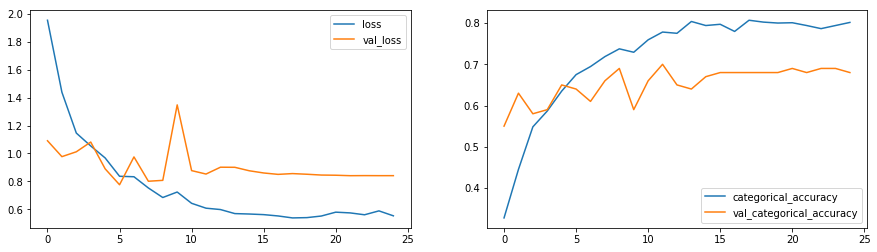

In [23]:
print("Total Parameterss:", conv_3d10_model.count_params())
model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)
plot(model10)

### Inferences (Model-10)

- Total Parameters: 504,709
- Categorical and validation accuracy are 80% and 68% respectively in the last epoch.

## Model 11 (similar to model 8)

In [24]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

Total Parameters: 2573541
Epoch 1/20
34/34 [==============================] - 96s 3s/step - loss: 1.4598 - categorical_accuracy: 0.3804 - val_loss: 1.1208 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2021-02-0718_58_28.265721/model-00001-1.47278-0.37330-1.12077-0.55000.h5
Epoch 2/20
34/34 [==============================] - 90s 3s/step - loss: 1.1077 - categorical_accuracy: 0.5478 - val_loss: 0.9766 - val_categorical_accuracy: 0.5900

Epoch 00002: saving model to model_init_2021-02-0718_58_28.265721/model-00002-1.10134-0.54902-0.97660-0.59000.h5
Epoch 3/20
34/34 [==============================] - 92s 3s/step - loss: 0.9482 - categorical_accuracy: 0.6111 - val_loss: 0.9460 - val_categorical_accuracy: 0.6200

Epoch 00003: saving model to model_init_2021-02-0718_58_28.265721/model-00003-0.95097-0.61388-0.94602-0.62000.h5
Epoch 4/20
34/34 [==============================] - 92s 3s/step - loss: 0.7117 - categorical_accuracy: 0.7196 - val_loss: 0.7994 - val_categ

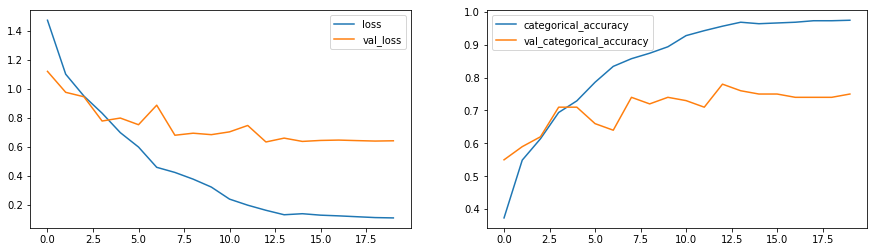

In [26]:
print("Total Parameters:", rnn_cnn2_model.count_params())
model11=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)
plot(model11)

### Inferences (Model-11)

- Total Parameters: 2,573,541
- Categorical and validation accuracy are 97% and 75% respectively in the last epoch.
- The augmentation seems to be not perfoming as we can see the model is overfitting.

Lets try MobileNet for Model building(Transfer Leaning) as it is light weight.

## Model 12 - Transfer Learning

We shall be using Mobilenet as it is lightweight in its architecture. It uses depthwise separable convolutions which basically means it performs a single convolution on each colour channel rather than combining all three and flattening it. This has the effect of filtering the input channels.

In [29]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [30]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_30 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_31 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_32 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
__________

Total Parameters: 3692869
Epoch 1/20
133/133 [==============================] - 92s 693ms/step - loss: 1.2098 - categorical_accuracy: 0.5060 - val_loss: 0.5733 - val_categorical_accuracy: 0.7700

Epoch 00001: saving model to model_init_2021-02-0722_03_31.059834/model-00001-1.21243-0.50452-0.57325-0.77000.h5
Epoch 2/20
133/133 [==============================] - 81s 608ms/step - loss: 0.7610 - categorical_accuracy: 0.7135 - val_loss: 0.5994 - val_categorical_accuracy: 0.7800

Epoch 00002: saving model to model_init_2021-02-0722_03_31.059834/model-00002-0.76256-0.71267-0.59936-0.78000.h5
Epoch 3/20
133/133 [==============================] - 81s 609ms/step - loss: 0.5676 - categorical_accuracy: 0.7817 - val_loss: 0.5889 - val_categorical_accuracy: 0.7800

Epoch 00003: saving model to model_init_2021-02-0722_03_31.059834/model-00003-0.56785-0.78205-0.58885-0.78000.h5
Epoch 4/20
133/133 [==============================] - 82s 618ms/step - loss: 0.4906 - categorical_accuracy: 0.8135 - val_loss

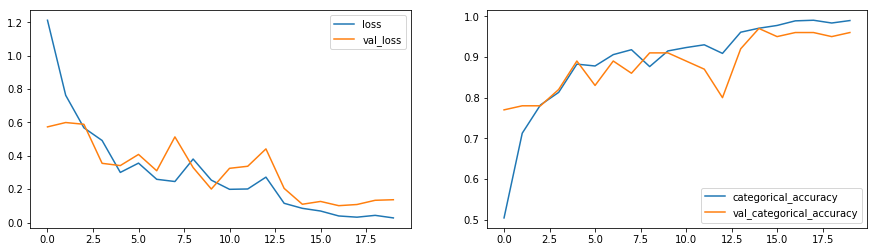

In [31]:
print("Total Parameters:", rnn_cnn_tl2_model.count_params())
model12=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)
plot(model12)

### Inferences (Model-12)

- Total Parameters: 3,692,869
- Categorical and validation accuracy are 98% and 96% respectively in the last epoch.
- The Model seems to be working with high accuracy.

## Model Evaluation

Based on the above experiments we have consolidated the models and their results as below:

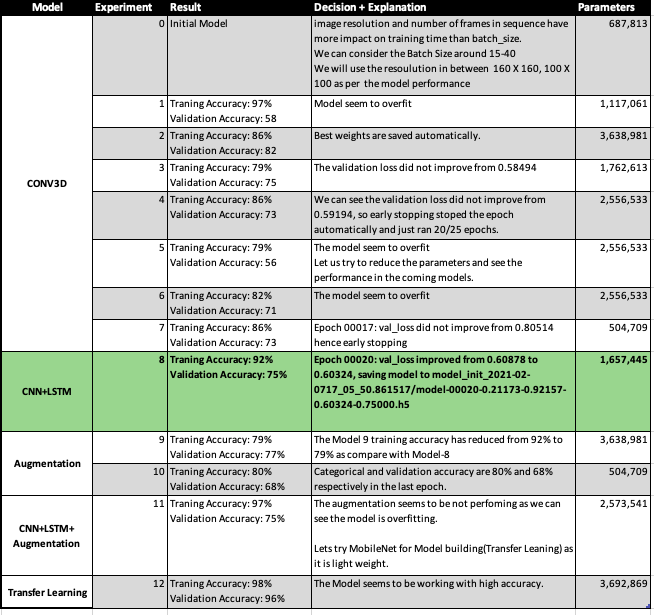

### After doing all the experiments, we finalized Model 8 - CNN+LSTM, which performed well.

**- (Training Accuracy : 92%, Validation Accuracy : 75%)**

**- Number of Parameters(1,657,445)less according to other models performance**

**- Epoch 00020: val_loss improved from 0.60878 to 0.60324, saving model to model_init_2021-02-0717_05_50.861517/model-00020-0.21173-0.92157-0.60324-0.75000.h5**

## Final model Testing

In [5]:
%%time
import time
from keras.models import load_model
model = load_model('model_init_2021-02-0717_05_50.861517/model-00020-0.21173-0.92157-0.60324-0.75000.h5')

CPU times: user 4.51 s, sys: 1.71 s, total: 6.22 s
Wall time: 20.7 s


In [8]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

In [9]:
%%time
g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

CPU times: user 1.34 s, sys: 139 ms, total: 1.48 s
Wall time: 3.56 s


In [10]:
batch_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [11]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[0 3 1 0 1 3 2 1 1 3 2 4 1 4 4 1 4 2 2 0]


### Conclusion:

- CPU times: user 1.34 s, sys: 139 ms, total: 1.48 s

The total time seems to be nominal for a gesture recognition model.
The detail explanation of model in the write-up document.
